In [ ]:
#dependencies
!pip install scvi-tools
!pip install scikit-misc
!pip install scanpy
!pip install leidenalg

In [27]:
import scvi
import scanpy as sc
import pandas as pd

from matplotlib.pyplot import rc_context
sc.set_figure_params(dpi=100)

In [28]:
adata = sc.read_10x_h5('lung1.h5')
adata.var_names_make_unique()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [29]:
adata

AnnData object with n_obs × n_vars = 12324 × 32286
    var: 'gene_ids', 'feature_types', 'genome'

In [30]:
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.highly_variable_genes(adata, n_top_genes = 3000, subset = True, flavor = 'seurat_v3')

In [31]:
adata

AnnData object with n_obs × n_vars = 12293 × 3000
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

In [32]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE

Epoch 400/400: 100%|██| 400/400 [03:45<00:00,  1.78it/s, loss=1.02e+03, v_num=1]


In [33]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                            


/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/400:  50%|███   | 200/400 [01:40<01:40,  1.98it/s, loss=0.31, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.297. Signaling Trainer to stop.


In [34]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)
df.index = df.index.map(lambda x: x[:-2])

df

,doublet,singlet,prediction
AAACCCAAGCAACAAT-1,0.162318,0.011546,doublet
AAACCCAAGGAGGGTG-1,-1.973931,1.833222,singlet
AAACCCAAGGTCCCTG-1,-0.582302,0.685274,singlet
AAACCCACAACGCATT-1,0.829180,-0.718261,doublet
AAACCCACACCAGCGT-1,1.558483,-1.355829,doublet
...,...,...,...
TTTGTTGCAGGACTTT-1,-0.314485,0.732823,singlet
TTTGTTGGTAGGCAAC-1,0.330435,-0.132764,doublet
TTTGTTGGTAGTCTGT-1,0.090117,0.313206,singlet
TTTGTTGGTCGCTGCA-1,-0.628668,1.046693,singlet


In [35]:
len(df[df.prediction == 'doublet'])

2386

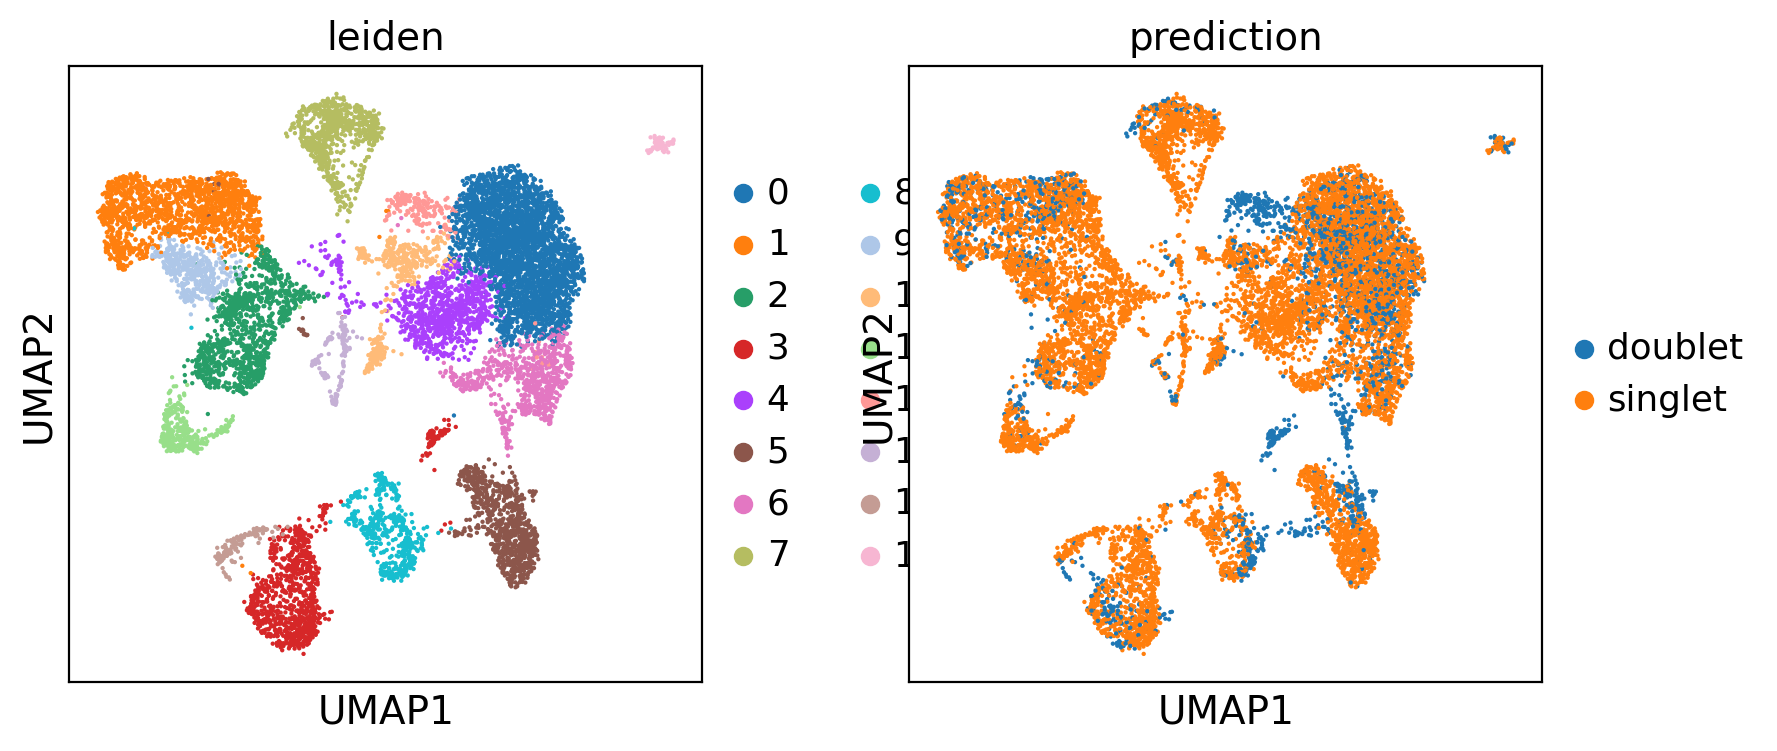

In [36]:
#THIS STEP IS NOT NECESSARY, just to visuallize results
adata.obs['prediction'] = df.prediction
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color = ['leiden', 'prediction'])

In [20]:
doublet_d = dict(zip(df.index, df.prediction))

def im_a_function(x):
    try:
        return doublet_d[x]
    except:
        return 'filtered'

In [21]:
adata = sc.read_10x_h5('lung1.h5')
adata.var_names_make_unique()

/home/jrlab2019/miniconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [23]:
adata.obs['doublet'] = adata.obs.index.map(im_a_function)

In [24]:
adata.obs

,doublet
AAACCCAAGCAACAAT-1,doublet
AAACCCAAGGAGGGTG-1,singlet
AAACCCAAGGTCCCTG-1,singlet
AAACCCACAACGCATT-1,doublet
AAACCCACACCAGCGT-1,doublet
...,...
TTTGTTGCAGGACTTT-1,singlet
TTTGTTGGTAGGCAAC-1,doublet
TTTGTTGGTAGTCTGT-1,singlet
TTTGTTGGTCGCTGCA-1,singlet


In [25]:
adata = adata[adata.obs.doublet == 'singlet']

In [26]:
adata

View of AnnData object with n_obs × n_vars = 10105 × 32286
    obs: 'doublet'
    var: 'gene_ids', 'feature_types', 'genome'